In [1]:
import unicodedata
from os import mkdir
from os import listdir
from pathlib import Path
import locale
import datetime
from datetime import timedelta
from dateutil.relativedelta import relativedelta

from bs4 import BeautifulSoup
import requests
import re
from lxml import etree
import urllib

import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
from IPython.core.display import HTML 

<br>

## <span style="color:blue">Point Vendée Globe</span>
 

In [2]:
# depart de la course 08-11-2020 à 12h02
deb_course = datetime.datetime.strptime("20-11-08-12-02-00", "%y-%m-%d-%H-%M-%S")
# record 74 j 03 h 35 min 46 s 
record = deb_course + datetime.timedelta(days=74, hours= 3, minutes=35, seconds =46)

diff = relativedelta(record, deb_course)
print('\n')
#source photo: wikipédia
print('Le record du Vendée Globe, 74j 3h 35min 46s, est actuellement detenu par Armel Le Cléac\'h (2016-2017):')
Image(url= "https://upload.wikimedia.org/wikipedia/commons/1/13/Vendée_Globe_2016_-_Armel_Le_Cléac%27h_%2830764004362%29.jpg", width=200, height=200)




Le record du Vendée Globe, 74j 3h 35min 46s, est actuellement detenu par Armel Le Cléac'h (2016-2017):


In [3]:
print('\n')
print( f'\x1B[1m\x1b[31mPour battre ce record, il reste {diff.months} mois {diff.days}j {diff.hours}h {diff.minutes}min et {diff.seconds}s, ou une arrivée avant {record.strftime("%d/%m/%Y: %H:%M:%S")}\x1b[0m')



Pour battre ce record, il reste 2 mois 13j 3h 35min et 46s, ou une arrivée avant 21/01/2021: 15:37:46


<br>

## Import des données Classement
<hr>

In [4]:
url = "https://www.vendeeglobe.org"
url_ranking = "https://www.vendeeglobe.org/fr/classement"

storage_path = Path("ranking")
Path(storage_path).absolute()

req = requests.get(url_ranking)
soup = BeautifulSoup(req.content, "lxml")

In [5]:
# download histo - ATTENTION AU TEMPS DE DOWNLOAD - Site indisponible temporairement vers 18h
download_dispo = re.findall('"(.*?)"', str(soup.findAll('select', class_ ='form__input m--select onsubmit-rank')))

a = soup.find("a", class_="rankings__download")
excel_url = url + a['href']

# Attention au temps - on télécharge les fichiers excel depuis le début ou les X derniers 
X = 5

lien_sans_date = a['href'][:-20]
for i in range (3, X+3):

    lien_date = f'{lien_sans_date}{download_dispo[i]}.xlsx'
    excel_url_histo = url + lien_date 

    req = requests.get(excel_url_histo)
    df = pd.read_excel(req.content)

    if not storage_path.exists():
        mkdir(storage_path)
    df.to_excel(storage_path / Path(excel_url_histo).name)

<br>

## Traitement donnéees
<hr>

In [6]:
# on retraite les coordonnnées GPS (code trouvé: https://gist.github.com/chrisjsimpson/076a82b51e8540a117e8aa5e793d06ec)

def dms2dec(dms_str):
    dms_str = re.sub(r'\s', '', dms_str)
    
    sign = -1 if re.search('[swSW]', dms_str) else 1
    numbers = [*filter(len, re.split('\D+', dms_str, maxsplit=4))]

    degree = numbers[0]
    minute = numbers[1] if len(numbers) >= 2 else '0'
    second = numbers[2] if len(numbers) >= 3 else '0'
    frac_seconds = numbers[3] if len(numbers) >= 4 else '0'
    
    second += "." + frac_seconds
    return sign * (int(degree) + float(minute) / 60 + float(second) / 3600)

In [7]:
#on construit les data frames
liste_fichier = listdir("ranking/")
list_fichier = sorted(liste_fichier)

df_list = list()
df = pd.DataFrame()
for i in range(1,len(list_fichier)):
    adr = f'{Path(storage_path).absolute()}/{list_fichier[i]}'
    df = pd.DataFrame()          
    df = pd.read_excel(adr)
        
    #on formate les colonnes
    df.drop(df.index[0:4],0,inplace=True)
   
    df = df.rename(columns={
                    'Unnamed: 1':'Rang',                'Unnamed: 2':'Nat/Voile', 
                    'Unnamed: 3':'Skipper/Bateau',      'Unnamed: 4': 'Heure FR',
                    'Unnamed: 5': 'Latitude' ,          'Unnamed: 6': 'Longitude',
                    'Unnamed: 12': 'Vitesse_last_kts',  'Unnamed: 13': 'VMG_last_kts',
                    'Unnamed: 19' : 'DTF_nm',           'Unnamed: 20' : 'DTL_nm'})
    df = df.drop(['Unnamed: 0','Unnamed: 0.1'], axis=1) 
    df["Date"] = list_fichier[i][12:16:1] + '-' + list_fichier[i][16:18:1] + '-'+ list_fichier[i][18:20:1] + ' ' + list_fichier[i][21:23:1] + ':' + list_fichier[i][23:25:1]
    df = df.drop(['Heure FR'], axis=1)    
    df["Skipper/Bateau"] = df["Skipper/Bateau"].str.rsplit("\n" , n=1, expand=True) # On ne prend que le nom du skippeur
    df = df.rename(columns={'Skipper/Bateau':'Skipper'})     
    df["Nat"] =  df['Nat/Voile'].str.extract('\n(...)')
    df["Voile"] = df["Nat/Voile"].str.rsplit(" " , n=3, expand=True)[1]
    df['DTF_nm'] =  df['DTF_nm'].str.rsplit(" nm", n=1, expand=True)[0]
    df['DTL_nm'] =  df['DTL_nm'].str.rsplit(" nm", n=1, expand=True)[0]
    df['Vitesse_last_kts'] =  df['Vitesse_last_kts'].str.rsplit(" kts", n=1, expand=True)[0]
    df['VMG_last_kts'] =  df['VMG_last_kts'].str.rsplit(" kts", n=1, expand=True)[0]
    df = df[['Date', 'Skipper',"Nat",'Voile','Latitude','Longitude','Vitesse_last_kts','VMG_last_kts','DTF_nm','DTL_nm','Rang']] # on selectionne les colonnes à garder  
    df = df.dropna() 
    df.reset_index(drop=True, inplace = True)
    df_list.append(df)

# On fabrique un gros DF avec tous les fichiers Excel
dfG = pd.DataFrame()
VMG_max = pd.DataFrame()
VMG_min = pd.DataFrame()
for j in range(0,len(list_fichier)-1):
    df_list[j]['Skipper'] = df_list[j]['Skipper'].apply(lambda x: x.split('\n')[0].lower())
    df_list[j]['Skipper'] = df_list[j]['Skipper'].str.normalize('NFKD').str.encode('ascii', errors='ignore').str.decode('utf-8')
    df_list[j]['Rang'] =  df_list[j]['Rang'].astype(float)
    df_list[j]['DTF_nm'] = df_list[j]['DTF_nm'].astype(float)
    df_list[j]['DTL_nm'] = df_list[j]['DTL_nm'].astype(float)
    df_list[j]['VMG_last_kts'] = df_list[j]['VMG_last_kts'].astype(float)
    df_list[j]['Vitesse_last_kts'] = df_list[j]['Vitesse_last_kts'].astype(float)
    df_list[j]['Date'] = pd.to_datetime(df_list[j]['Date'],format='%Y-%m-%d %H:%M')
    df_list[j]["Voile"] = df_list[j]["Voile"].astype(int)
    dfG = pd.concat( [dfG , df_list[j]])
    
# format
dfG["Latitude"] = dfG['Latitude'].apply(dms2dec)
dfG["Longitude"]= dfG['Longitude'].apply(dms2dec)
df_list[-1]["Latitude"] = df_list[-1]['Latitude'].apply(dms2dec)
df_list[-1]["Longitude"] = df_list[-1]['Longitude'].apply(dms2dec)

dfG.tail(2)

Date              Skipper  Nat  Voile   Latitude  Longitude  \
30 2020-11-30 17:00:00  sebastien destremau  FRA     69 -17.235278 -33.039444   
31 2020-11-30 17:00:00        jeremie beyou  FRA      8  -7.156944 -31.706111   

    Vitesse_last_kts  VMG_last_kts   DTF_nm  DTL_nm  Rang  
30              11.4          10.1  20570.6  2923.6  31.0  
31              16.2          12.3  21045.1  3398.1  32.0

<br>

###  <u> Analyse Nationalité des skippers </u>

In [8]:
last_nb_skipper = len(df_list[-1])
print(f'Il y actuellement {last_nb_skipper} skippers en course.')

Il y actuellement 32 skippers en course.


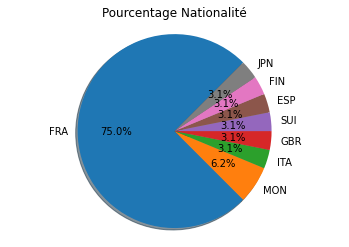

In [9]:
#camembert des nationalités
df_list[-1]['Nat'].value_counts()

labels = df_list[-1]['Nat'].unique() # nationalité
sizes = df_list[-1]['Nat'].value_counts() # nb / nationalité

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%', shadow=True, startangle=45)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title("Pourcentage Nationalité")
plt.show()

#faire plutot un double donut
#https://python-graph-gallery.com/163-donut-plot-with-subgroups/

In [10]:
# Nationalité des 3 premiers de la course
df_list[1]["Nat"].loc[df_list[1]["Rang"]<4].unique

<bound method Series.unique of 0    FRA
1    FRA
2    GBR
Name: Nat, dtype: object>

<br>

## <u>Position course</u>
<hr>

#### <u>Classement en distance mille marin</u>

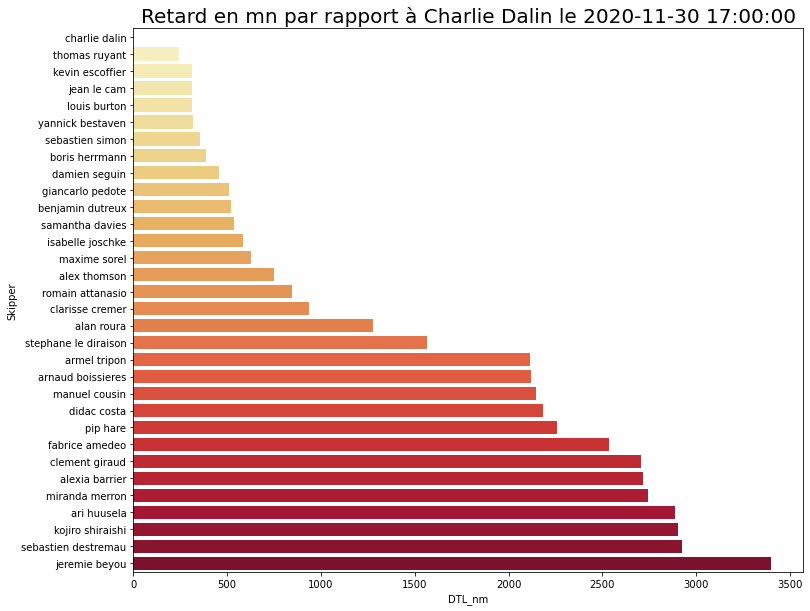

In [11]:
# graph pour illustrer la position des skippers par rapport au premier en terme de retard en mille nautique
first = df_list[-1]['Skipper'][df_list[-1]['DTL_nm']==0].to_string(index=False);
premier= first.title()
date_dernier_classement = df_list[-1].at[1,"Date"]
plt.figure(figsize=(12, 10))
plt.title(f'Retard en mn par rapport à{premier} le {date_dernier_classement}', fontsize = 20)
sns.barplot(data=df_list[-1], x='DTL_nm', y='Skipper', palette='YlOrRd');


<br>

#### <u>Position des Skippers</u>

In [12]:
import random
import folium

lat_first = df_list[-1][['Latitude']][(df_list[-1]["Rang"] == 1)].astype(float)
long_first = df_list[-1][['Longitude']][(df_list[-1]["Rang"] == 1)].astype(float)

# on centre la carte par rapport au premier 
map_osm = folium.Map(location=[lat_first.Latitude[0], long_first.Longitude[0]], zoom_start=2.5)

skipper_name = df_list[3][['Skipper']]
skipper_name = skipper_name.set_index('Skipper')
liste_skippers = skipper_name.index.values.tolist()

# on genère une palette de couleur par voilier
colors = []
n = len(df_list[3][['Skipper']])
for i in range(n):
    colors.append('#%06X' % random.randint(0, 0xFFFFFF))
colors

#dictionnaire couleur/skipper
dico = {}
j = 0
for k in liste_skippers:
    dico[k]=colors[j-4]
    j+=1
dico

for index ,lat, lon, skipper in dfG[['Latitude', 'Longitude', 'Skipper']][:].itertuples():
    map_osm.add_child(folium.RegularPolygonMarker(location=[lat,lon], popup=skipper, numberOfSides= 5,fillOpacity= 1,
                       weight = 2, color=dico[skipper], radius=1, fg = folium.FeatureGroup("Lines")))

# Pour ne pas polluer la carte, je choisis d'afficher le marker du 1ier et du dernier de la course                                              
#premier de la course
folium.Marker(location=df_list[-1][['Latitude', 'Longitude']].loc[(df_list[-1]['DTL_nm'] == 0)],
    popup="1er: " + df_list[-1][['Skipper']].loc[(df_list[-1]['DTL_nm'] == 0)].to_string(index=False), 
              icon=folium.Icon(color='green')).add_to(map_osm) 

#dernier de la course
#couleur_last = dico[df_list[-1].loc[df_list[-1]['Rang'].idxmax(), ('Skipper')]] -> n'existe pas pour folium marker
folium.Marker(location=df_list[-1].loc[df_list[-1]['DTL_nm'].idxmax(), ['Latitude','Longitude']],
    popup="Dernier: " + df_list[-1].loc[df_list[-1]['DTL_nm'].idxmax(),['Skipper']].to_string(index=False), 
              icon=folium.Icon(color='red')).add_to(map_osm) 

map_osm

<br>

## Import des données Voiliers
<hr>

In [13]:
# on collecte les données sur les voiliers
url = 'https://www.vendeeglobe.org/fr/glossaire'
content = requests.get(url).content.decode('utf-8')
soup = BeautifulSoup(content, 'html.parser')

list_dico=[]
for tok in soup.findAll("div",{'class':['boats-list__popup mfp-hide']}):
    dico ={}
    try:
        for i in range(0,14):
            dico[tok.findAll('li')[i].text.split(":")[0]]=tok.findAll('li')[i].text.split(":")[1]
        dico['Skipper']=tok.find('a',class_='boats-list__popup-skipper-link').attrs['href'].split('/')[-1]
        list_dico.append(dico)
            
    except IndexError:
        try:
            for i in range(0,13):
                dico[tok.findAll('li')[i].text.split(":")[0]]=tok.findAll('li')[i].text.split(":")[1]
            dico['Skipper']=tok.find('a',class_='boats-list__popup-skipper-link').attrs['href'].split('/')[-1]
            list_dico.append(dico)
                
        except IndexError:
            for i in range(0,12):
                dico[tok.findAll('li')[i].text.split(":")[0]]=tok.findAll('li')[i].text.split(":")[1]
            dico['Skipper']=tok.find('a',class_='boats-list__popup-skipper-link').attrs['href'].split('/')[-1]
            list_dico.append(dico)
voilier=pd.DataFrame(list_dico)  

#format
voilier = voilier.rename(columns={
                                voilier.columns[0]: 'Num_voilier', voilier.columns[1]: 'Ancien_nom',
                                voilier.columns[2]: 'Architecte', voilier.columns[3]: 'Chantier',
                                voilier.columns[4]: 'Date_lanct', voilier.columns[5]: 'Longueur_m',
                                voilier.columns[6]: 'Largueur_m',voilier.columns[7]: 'Tirant_eau',
                                voilier.columns[8]: 'Poids', voilier.columns[9]: 'Foil',
                                voilier.columns[10]: 'Hauteur_mat',voilier.columns[11]: 'Voile_quile',
                                voilier.columns[12]: 'Surface_voile_pres', voilier.columns[13]: 'Surface_voile_portant'})

voilier['Skipper']=voilier['Skipper'].replace('-', ' ', regex=True)
voilier = voilier.drop(['Ancien_nom'], axis=1) 

#format
locale.setlocale(locale.LC_ALL, 'fr_FR')
voilier['Date_lanct'] = pd.to_datetime(voilier['Date_lanct'],format=' %d %B %Y')

voilier['Longueur_m'] =  voilier['Longueur_m'].str.rsplit((" m" and "m"), n=1, expand=True)[0]
voilier['Longueur_m']=  voilier['Longueur_m'].replace(',', '.', regex=True).astype(float)

voilier['Largueur_m'] =  voilier['Largueur_m'].str.rsplit((" m" and "m"), n=1, expand=True)[0]
voilier['Largueur_m']=  voilier['Largueur_m'].replace(',', '.', regex=True).astype(float)

voilier['Poids'] =  voilier['Poids'].str.rsplit((" t" and "t"), n=2, expand=True).replace(',', '.', regex=True)[0]

voilier['Surface_voile_pres'] =  voilier['Surface_voile_pres'].str.rsplit((" m2"), n=1, expand=True)[0]
voilier['Surface_voile_pres'] =  voilier['Surface_voile_pres'].str.rsplit(" m²", n=1, expand=True)[0]
voilier['Surface_voile_pres'] =  voilier['Surface_voile_pres'].astype(float)

voilier['Surface_voile_portant'] =  voilier['Surface_voile_portant'].str.rsplit((" m2"), n=1, expand=True)[0]
voilier['Surface_voile_portant'] =  voilier['Surface_voile_portant'].str.rsplit(" m²", n=1, expand=True)[0]
voilier['Surface_voile_portant'] =  voilier['Surface_voile_portant'].astype(float)

voilier['Tirant_eau'] =  voilier['Tirant_eau'].str.rsplit((" m" and "m"), n=1, expand=True)[0]
voilier['Tirant_eau']=  voilier['Tirant_eau'].replace(',', '.', regex=True).astype(float)


voilier['Hauteur_mat'] =  voilier['Hauteur_mat'].str.rsplit((" m" and "m"), n=1, expand=True).replace(',', '.', regex=True)[0]
voilier['Hauteur_mat'] = pd.to_numeric(voilier['Hauteur_mat'],errors='coerce')

voilier['Foil'] = voilier['Foil'].map({' 2 asymétriques':0 , ' 2' : 0, ' foiler':1, ' foils':1}).astype(float)
voilier['Skipper']=  voilier['Skipper'].replace('sam davies', 'samantha davies', regex=True)

voilier = voilier.drop_duplicates()
voilier = voilier.drop(["Num_voilier", "Architecte","Chantier"], axis=1) 

voilier = voilier.reset_index(drop=True)
voilier = voilier.dropna() # on retire le bateau de nicolas troussel qui n'est plus en course 
    
voilier.head(2) 

Date_lanct  Longueur_m  Largueur_m  Tirant_eau Poids  Foil  Hauteur_mat  \
0 2015-08-01       18.28        5.85         4.5    7    1.0         29.0   
1 2007-03-08       18.28        5.80         4.5     9   0.0         28.0   

    Voile_quile  Surface_voile_pres  Surface_voile_portant           Skipper  
0      monotype               320.0                  570.0    fabrice amedeo  
1   acier forgé               280.0                  560.0  romain attanasio

In [14]:
#dataframe global avec les info voiliers
df_last_voilier = pd.merge(df_list[-1],voilier, left_on='Skipper', right_on='Skipper', how='left')
df_last_voilier = df_last_voilier[['Date', 'Skipper',"Nat",'Voile','Date_lanct','Foil','Latitude','Longitude','Vitesse_last_kts','VMG_last_kts','DTF_nm','DTL_nm', 'Longueur_m', 'Largueur_m', 'Tirant_eau','Poids', 'Hauteur_mat', 'Surface_voile_pres', 'Surface_voile_portant','Voile_quile', 'Rang']] 
df_last_voilier.reset_index(drop=True, inplace = True)

#data global + info voilier
dfG_voilier = pd.merge(dfG,voilier, left_on='Skipper', right_on='Skipper', how='left')
dfG_voilier.reset_index(drop=True, inplace = True)
dfG_voilier.head(2)

Date         Skipper  Nat  Voile   Latitude  Longitude  \
0 2020-11-08 14:00:00    louis burton  FRA     18  46.412778  -1.846667   
1 2020-11-08 14:00:00  boris herrmann  MON     10  46.409444  -1.839444   

   Vitesse_last_kts  VMG_last_kts   DTF_nm  DTL_nm  ...  Date_lanct  \
0               0.0           0.0  24293.9     0.0  ...  2015-06-09   
1               0.0           0.0  24294.2     0.4  ...  2015-08-07   

  Longueur_m  Largueur_m  Tirant_eau  Poids Foil  Hauteur_mat  Voile_quile  \
0      18.28         5.8         4.5   7.6   1.0         28.0        acier   
1      18.28         5.7         4.5   7.6   1.0         29.0        acier   

  Surface_voile_pres  Surface_voile_portant  
0              300.0                  600.0  
1              290.0                  490.0  

[2 rows x 21 columns]

<br>

## VGM / Vitesse - Foil ou pas foil, impact sur le classement
<hr>

#### <u>Etude de corrélation</u>

In [15]:
# correlation matrice sur le dernier classement
df_correl = df_last_voilier[['Vitesse_last_kts', 'VMG_last_kts','Largueur_m','Hauteur_mat', 'Surface_voile_pres', 'Surface_voile_portant',  'Rang']] 
corrLast = df_correl.corr()
corrLast.style.background_gradient(cmap='RdYlGn') #coolwarm
#on retire 'Longueur_m' et 'tirant_eau' car tous les voiliers ont les mêmes caractéristiques

<br>
<span style="font-family:Comic Sans MS", size=13>Parmi les 3 variables les plus correlés avec le rang, on retrouve bien la vitesse et la VMG. Ceci de façon négative, car plus la vitesse et la VMG sont élevées plus le rang est petit (tête de course). La surface de la voile_pres étant l'autre variables importante.  </span>
<br><br>
<span style="font-family:Comic Sans MS", size=13>N'ayant pas de connaissance en voile, pour répondre à la question sur les foils, mes recherches m'ont permis de comprendre que le foil a pour objectif de dévier l'eau vers le fond (action). En réaction, le foil subit une force verticale, la portance. Grace à cette portance, le voilier navigue de façon plus aérienne, réduit la surface de contact avec l'eau, donc la trainée et permet au voilier d'aller plus vite....</span>
<br><br>
<span style="font-family:Comic Sans MS", size=13>Aussi, aurais-je voulu mesurer la corrélation de la variable "Poids" sur le rang. Or, pour 2 voiliers encore en course, il me manque cette donnée....</span>
<br><br>
<span style="font-family:Comic Sans MS", size=13>Par conséquent, je consacrai la partie algo à classifier les voiliers afin de me permettre de déduire le poids de ces deux voiliers (prendre la moyenne de leur cluster au lieu de retenir une règle arbitraire:  moyenne générale, moyenne des voiliers ayant la même matière de quile, poids du voilier ayant date de lancement la plus proche, etc....) et ainsi calculer la corrélation, afin de confirmer ou affirmer cette intuition.</span> 
<br><br>

In [16]:
# correlation matrix sur les moyennes des classements la course
df_moy_course = dfG.loc[:, ['Date', 'Skipper' ,'VMG_last_kts', 'Vitesse_last_kts', 'Rang']].groupby(['Date', 'Skipper']).mean()
df_moy_course_voile = pd.merge(df_moy_course,df_last_voilier[['Skipper','Foil']],on='Skipper', how='right')# on recupère la donnée foil
df_moy_course_voile = df_moy_course_voile.dropna() #33ième concurrence sorti de la course, présent au début

df_moy_voile_correl = df_moy_course_voile[['Vitesse_last_kts', 'VMG_last_kts','Rang']] # pour avoir même ordre des colonnes
corrGlob = df_moy_voile_correl.corr()
corrGlob.style.background_gradient(cmap='RdYlGn')

<br>
<span style="font-family:Comic Sans MS",size=13>Si on prend l'ensemble des données de la course (nous avons pris la moyenne arithmétique) concernant la vitesses, VMG et rang, la corrélation négative est toujours très présente.</span> 
<br><br>
<span style="font-family:Comic Sans MS", size=13>Les graphiques ci-dessous montrent l'importance, d'une part, d'avoir une bonne vitesse et d'autre part une grande VMG pour être dans le peloton de tête. La très forte corrélation entre ces deux données indiquent également cette relation. Il n'est pas possible d'avoir une vitesse de rapprochement au but (VMG) importante sans vitesse élevée. La corrélation n'est pas parfaitement linéaire, car il faut également prendre en compte d'autres critères pour expliquer le classement. </span>
<br><br>

<br>

#### <u>Vitesse / VMG et classement</u>

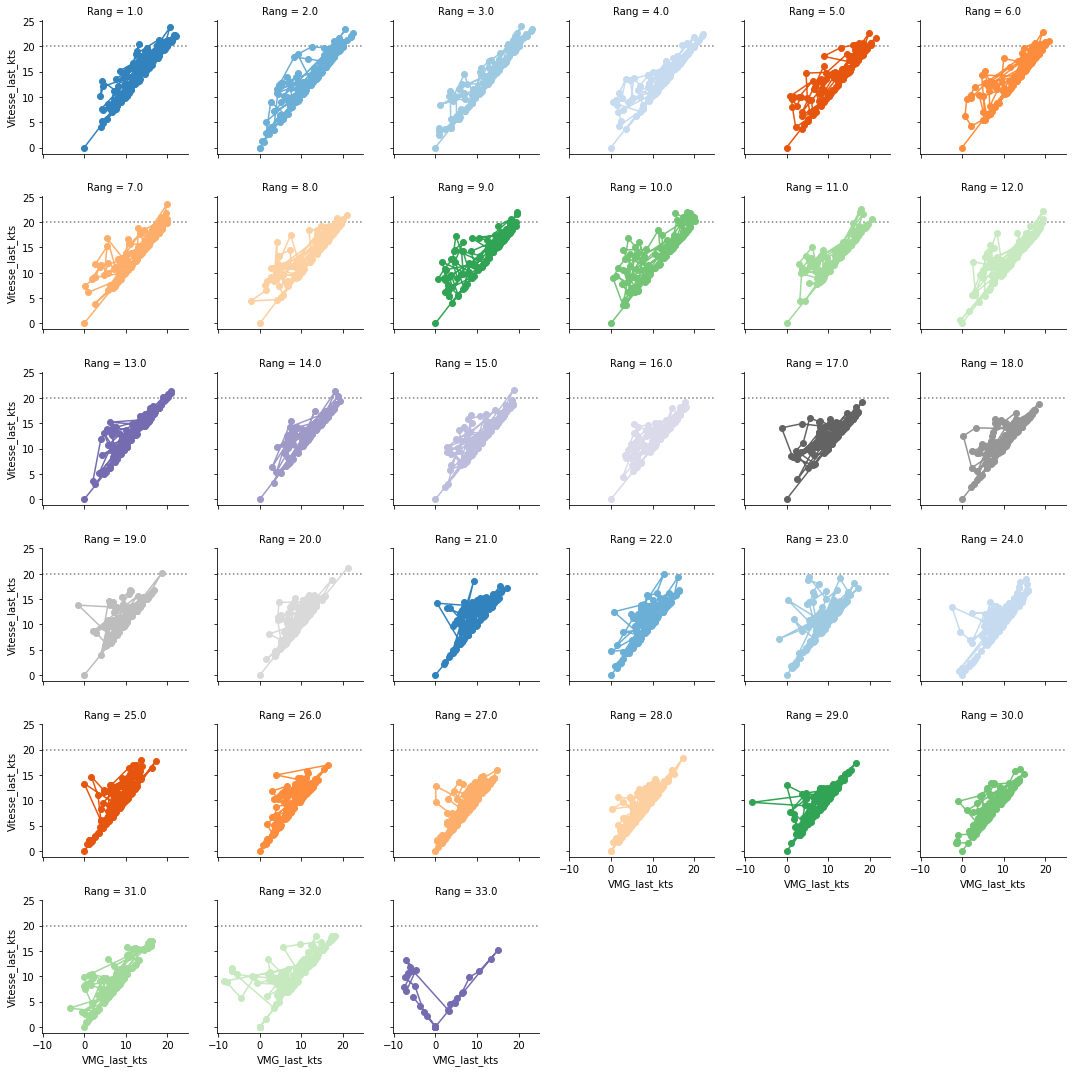

In [17]:
df_vitesse_vmg = dfG[["Vitesse_last_kts", "VMG_last_kts", "Skipper", "Rang"]]
grid = sns.FacetGrid(df_vitesse_vmg, col="Rang", hue="Rang", palette="tab20c",col_wrap=6, height=2.5) 
grid.map(plt.axhline, y=20, ls=":", c=".5")
grid.map(plt.plot,  "VMG_last_kts","Vitesse_last_kts", marker="o")
grid.fig.tight_layout(w_pad=2)

<br>

#### <u>Foil ou pas foil, quel impact sur le classement? </u>

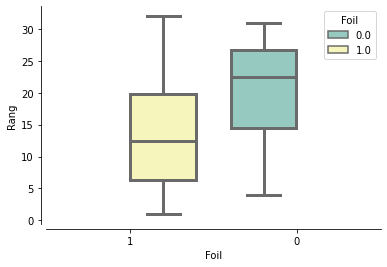

In [18]:
# Présence ou non de foil par rapport au rang dans la course
sns.boxplot(x="Foil", y="Rang", hue="Foil", palette="Set3", data=df_last_voilier[['Foil','Rang']], 
            linewidth=3, order=[1, 0])
sns.despine(offset=5, trim=False)

<br>
<span style="font-family:Comic Sans MS",size=13>Ce graphique révèle que la mediane du classement des voiliers avec un foil (1) est bien plus petite (donc meilleur rang)</span> 
<br><br>
<span style="font-family:Comic Sans MS", size=13>Sachant que les foils sont apparus sur les voiliers de la vendée globe cette année, une nouvelle technologie, regardons de plus près l'impact de l'âge du voilier. Néanmoins, gardons à l'esprit qu'il est possible d'ajouter les foils sur des anciens voiliers, c'est notamment le cas du voilier d'Arnaud Boissieres (construit en 2007 il est pourvu d'un foil). </span>
<br><br>


In [19]:
anciennete_voilier = df_last_voilier[['Rang', 'Foil']].merge((df_last_voilier.Date_lanct.dt.year).to_frame(), 
                                                             left_index=True, right_index=True)
Age_etude= anciennete_voilier.groupby(['Date_lanct', 
                                       'Foil']).agg({'Rang': ['min', 'max', 'mean','median','count']})
Age_etude

Rang                          
                  min   max   mean median count
Date_lanct Foil                                
1998       0.0   27.0  27.0  27.00   27.0     1
1999       0.0   24.0  24.0  24.00   24.0     1
2000       0.0   23.0  23.0  23.00   23.0     1
2005       0.0   31.0  31.0  31.00   31.0     1
2006       0.0   26.0  28.0  27.00   27.0     2
2007       0.0    4.0  29.0  16.00   15.0     6
           1.0   13.0  21.0  17.75   18.5     4
2008       0.0    9.0   9.0   9.00    9.0     1
2010       1.0    3.0  12.0   7.50    7.5     2
2011       0.0   17.0  17.0  17.00   17.0     1
2015       1.0    5.0  25.0  10.80    8.0     5
2018       1.0   32.0  32.0  32.00   32.0     1
2019       1.0    1.0  30.0  11.00    7.0     5
2020       1.0   20.0  20.0  20.00   20.0     1

<br>
<span style="font-family:Comic Sans MS", size=13>Le boxplot montre bien l'impact du foil sur le classement. Néanmoins, si nous regardons de plus près l'année 2007, nous observons que le rang moyen/mediane des voiliers construit cette année, ceux sans foil ont même mieux performés. </span>
<br><br>
<span style="font-family:Comic Sans MS", size=13>Aussi, pouvons-nous supposer que l'impact du foil est à combiner avec d'autres caractéristiques.....</span>
<br><br>
<span style="font-family:Comic Sans MS", size=13>Et si le très bon classement de Jean Le Cam, doyen de la course, sur un "ancien" voilier, sans foil, nous laissait penser qu'il faut aussi chercher ailleurs que sur les caractéristiques techniques/materiels....peut-être une des varaibles explicatives pourrait être l'expérience...</span>
<br><br>

<br>

## Algo - K-mean
<hr>

In [20]:
# Traitement pour la variable categorielle, on affecte une valeur à chaque type de quile différent
df_last_voilier['Voile_quile'] = df_last_voilier['Voile_quile'].map({' monotype':1 , 
                                       ' acier forgé' : 2, 
                                       ' acier':3, 
                                       ' acier mécano soudé':4, 
                                       ' Acier mécano soudé':4,              
                                       ' basculante avec vérin':5, 
                                       ' basculante sur vérin hydraulique':6, 
                                       ' carbone':7, 
                                       ' Inox usiné':8}).astype(float)

df_last_voilier.head(2)

Date        Skipper  Nat  Voile Date_lanct  Foil   Latitude  \
0 2020-11-30 17:00:00  charlie dalin  FRA     79 2019-08-05   1.0 -40.659167   
1 2020-11-30 17:00:00  thomas ruyant  FRA     59 2019-09-03   1.0 -41.050556   

   Longitude  Vitesse_last_kts  VMG_last_kts  ...  DTL_nm  Longueur_m  \
0  16.468611              17.4          16.2  ...     0.0       18.28   
1  10.819167              15.9          15.9  ...   241.8       18.28   

   Largueur_m  Tirant_eau  Poids Hauteur_mat  Surface_voile_pres  \
0        5.85         4.5     8         29.0               350.0   
1        5.85         4.5     8         29.0               350.0   

   Surface_voile_portant  Voile_quile  Rang  
0                  560.0          3.0   1.0  
1                  560.0          2.0   2.0  

[2 rows x 21 columns]

In [21]:
data_voilier_sans_rang =  df_last_voilier[["Longueur_m", "Largueur_m","Foil", "Tirant_eau", "Hauteur_mat", "Voile_quile","Surface_voile_pres","Surface_voile_portant"]]


<br>

#### <u>Algo</u>


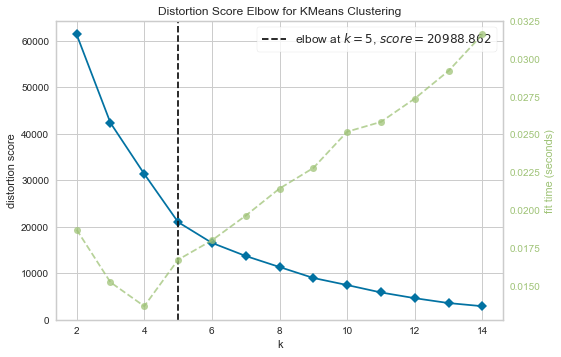

In [22]:
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

kmeans = KMeans()
visualizer = KElbowVisualizer(kmeans, k=(2,15))
visualizer.fit(data_voilier_sans_rang)

visualizer.poof();

<br>
<span style="font-family:Comic Sans MS", size=13>Le graphique nous permet de visualiser rapidement que le nombre de cluster à considérer est 5. </span>
<br>

In [23]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=5)
k_fit = kmeans.fit(data_voilier_sans_rang)

#on fait apparaitre les prédictions, quel cluster, pour chaque voilier
predictions = k_fit.labels_
data_voilier_sans_rang['Clusters'] = pd.DataFrame(predictions)

In [24]:
# on fusionne les tableaux sur les voiliers en incluant la colonne "Poids"
data_voilier_rang_skipper_cluster =  df_last_voilier[["Skipper", "Poids","Rang"]]
df_Poids = pd.concat([data_voilier_rang_skipper_cluster,data_voilier_sans_rang],axis=1, join='inner')

In [25]:
# on retrouve les données manquantes, on a au préalable remplacé par 0 les valeurs "NC"
df_Poids['Poids']  = pd.to_numeric(df_Poids['Poids'] , errors='coerce').fillna('0').astype(float)
df_Poids.loc[df_Poids['Poids']==0]

# => le 1ier poids manquant est le voilier de kevin escoffier
# => le 2ième poids manquant est le voilier de alan roura 

Skipper  Poids  Rang  Longueur_m  Largueur_m  Foil  Tirant_eau  \
2   kevin escoffier    0.0   3.0       18.28         5.5   1.0         4.5   
17       alan roura    0.0  18.0       18.28         5.9   1.0         4.5   

    Hauteur_mat  Voile_quile  Surface_voile_pres  Surface_voile_portant  \
2          27.4          4.0               300.0                  600.0   
17         27.0          7.0               290.0                  580.0   

    Clusters  
2          2  
17         3

In [26]:
# kmeans part de points aléatoire pour faire les clusters. 
# Meme si le résultats est le meme, les numéros de clusters peuvent varier. 
# Il faut donc récupérer le numéro pour chacun des 2 voiliers

Escoffier_voilier_Cluster = df_Poids[['Clusters']][(df_Poids["Skipper"] == 'kevin escoffier')].astype(float)
Escoffier_num_cluster = Escoffier_voilier_Cluster.iloc[0]["Clusters"]

Roura_voilier_Cluster = df_Poids[['Clusters']][(df_Poids["Skipper"] == 'alan roura')].astype(float)
Roura_num_cluster = Roura_num_cluster = Roura_voilier_Cluster.iloc[0]["Clusters"]

<br>

On va remplacer les valeurs manquantes par les valeurs moyennes du cluster.

##### <u>Voilier de kevin Escoffier</u>

In [27]:
# calcul du 'poids' du Cluster concerné 
sumClusterEscoffier = df_Poids['Poids'].loc[(df_Poids['Clusters']== Escoffier_num_cluster)].sum()
nb_ClusterEscoffier = len( df_Poids['Poids'].loc[(df_Poids['Clusters']== Escoffier_num_cluster)])
Escoffier_poids_voilier = round(sumClusterEscoffier/(nb_ClusterEscoffier-1),1)

df_Poids[df_Poids["Skipper"] == 'kevin escoffier']

Skipper  Poids  Rang  Longueur_m  Largueur_m  Foil  Tirant_eau  \
2  kevin escoffier    0.0   3.0       18.28         5.5   1.0         4.5   

   Hauteur_mat  Voile_quile  Surface_voile_pres  Surface_voile_portant  \
2         27.4          4.0               300.0                  600.0   

   Clusters  
2         2

In [28]:
# on complète le poids pour le voilier de kevin escoffier
EscoffierIndex = df_Poids.index[df_Poids["Skipper"] == 'kevin escoffier']
df_Poids.at[EscoffierIndex[0], 'Poids'] = Escoffier_poids_voilier
df_Poids[df_Poids["Skipper"] == 'kevin escoffier']

Skipper  Poids  Rang  Longueur_m  Largueur_m  Foil  Tirant_eau  \
2  kevin escoffier    8.0   3.0       18.28         5.5   1.0         4.5   

   Hauteur_mat  Voile_quile  Surface_voile_pres  Surface_voile_portant  \
2         27.4          4.0               300.0                  600.0   

   Clusters  
2         2

##### <u>Voilier d'Alan Roura</u>

In [29]:
# calcul du 'poids' du Cluster concerné 
sumClusterRoura = df_Poids['Poids'].loc[(df_Poids['Clusters']== Roura_num_cluster)].sum()
nb_ClusterRoura = len( df_Poids['Poids'].loc[(df_Poids['Clusters']== Roura_num_cluster)])
Roura_poids_voilier = round(sumClusterRoura/(nb_ClusterRoura-1),1)

df_Poids[df_Poids["Skipper"] == 'alan roura']

Skipper  Poids  Rang  Longueur_m  Largueur_m  Foil  Tirant_eau  \
17  alan roura    0.0  18.0       18.28         5.9   1.0         4.5   

    Hauteur_mat  Voile_quile  Surface_voile_pres  Surface_voile_portant  \
17         27.0          7.0               290.0                  580.0   

    Clusters  
17         3

In [30]:
RouraIndex = df_Poids.index[df_Poids["Skipper"] == 'alan roura']
df_Poids.at[RouraIndex[0], 'Poids'] = (Roura_poids_voilier.astype(float))
df_Poids[df_Poids["Skipper"] == 'alan roura']

Skipper  Poids  Rang  Longueur_m  Largueur_m  Foil  Tirant_eau  \
17  alan roura    8.5  18.0       18.28         5.9   1.0         4.5   

    Hauteur_mat  Voile_quile  Surface_voile_pres  Surface_voile_portant  \
17         27.0          7.0               290.0                  580.0   

    Clusters  
17         3

<br>

#### <u>Etude de correlétion sur le poids et le classement du Skipper</u>

In [31]:
df_Poids = df_Poids[['Longueur_m','Largueur_m','Foil', 'Tirant_eau', 'Hauteur_mat', 
                     'Voile_quile', 'Surface_voile_pres', 'Surface_voile_portant','Poids','Rang']]
df_Poids.head(2)

Longueur_m  Largueur_m  Foil  Tirant_eau  Hauteur_mat  Voile_quile  \
0       18.28        5.85   1.0         4.5         29.0          3.0   
1       18.28        5.85   1.0         4.5         29.0          2.0   

   Surface_voile_pres  Surface_voile_portant  Poids  Rang  
0               350.0                  560.0    8.0   1.0  
1               350.0                  560.0    8.0   2.0

In [32]:
df_Poids_correl = df_Poids[['Surface_voile_pres','Poids' , 'Rang']]
corrPoids = df_Poids_correl.corr()
corrPoids.style.background_gradient(cmap='RdYlGn')


<br>
<span style="font-family:Comic Sans MS", size=13>De façon aussi importante que la vitesse et la VMG, le poids du voiliers est bien corrélé au rang.</span>
<br>
<span style="font-family:Comic Sans MS", size=13>Les caractéristiques des voiliers qui expliquent le mieux le classement sont: foil, voile, et poids d'après les informations que nous avons étudiées .</span>
<br>

<br>

## Temps fort de la course - Analyse série temporelle
<hr>

#### <u>A quelle moment les écarts se sont-ils creusés?</u>

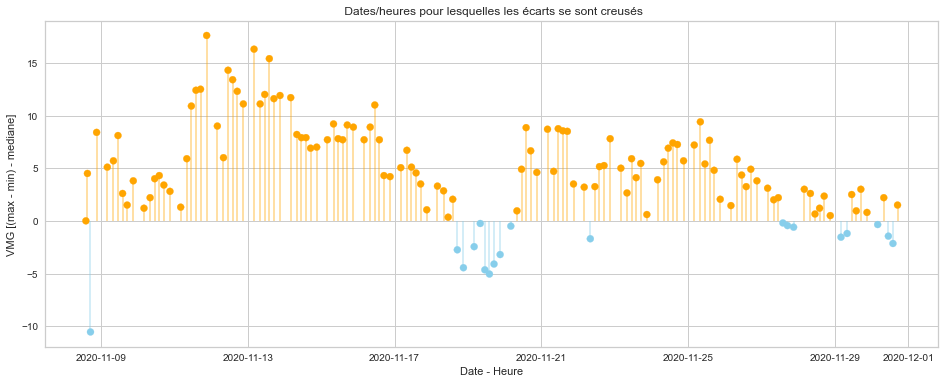

In [33]:
# pour chaque classement donnée, avec 6 par jour, nous calculons la VMG la plus importante et la plus faible. 
# Nous retirons ensuite la médiane pour bien distinguer les moments ou les écarts ne sont creusés entre les skippers
VMG_etude= dfG.groupby('Date').agg({'VMG_last_kts': ['min', 'max', 'median']})
VMG_min = VMG_etude.loc[:, ('VMG_last_kts', 'min')]
VMG_max = VMG_etude.loc[:, ('VMG_last_kts', 'max')]
VMG_median = VMG_etude.loc[:, ('VMG_last_kts', 'median')];

x = VMG_etude.index
y = (VMG_max - VMG_min) - VMG_median

my_color=np.where(y>=0, 'orange', 'skyblue')
 
plt.figure(figsize=(16, 6))

plt.vlines(x=x, ymin=0, ymax=y, color=my_color, alpha=0.4)
plt.scatter(x, y, color=my_color , alpha=1) #s=2
 
plt.title(" Dates/heures pour lesquelles les écarts se sont creusés", loc='center')
plt.xlabel('Date - Heure')
plt.ylabel('VMG [(max - min) - mediane]');

<br>

## <span style="color:blue">Point record</span>

In [34]:
import locale
locale.setlocale(locale.LC_ALL, 'fr_FR')
# -----------record (74 j 03 h 35 min 46 s)------------
jour = 74 * (24 *60 *60)
heure = 3 * (60 *60)
minute = 35 * (60)
seconde = 46
record_seconde = jour + heure + minute + seconde
# soit distance par seconde
distance_record_sec = 24300/record_seconde
distance_minute_min = distance_record_sec * 60
distance_record_heure = distance_minute_min * 60 

# ---------moyenne du 1er du classement -----------------
deb_course = datetime.datetime.strptime("20-11-08-12-02-00", "%y-%m-%d-%H-%M-%S") # depart de la course 08-11-2020 à 12h02
last_date= df_list[-1]['Date'][0:1:1]
distance_parcourue=  24300 - (df_list[-1]['DTF_nm'][df_list[-1]['DTL_nm']==0])
compteur_date = last_date - deb_course
distance_heure = distance_parcourue / (compteur_date.dt.components['days']*24 + compteur_date.dt.components['hours']) # + compteur_date.dt.components['minutes'])

#-------------arrivée prévisionnelle --------------------
heure_necessaire_first = (df_list[-1]["DTF_nm"].loc[df_list[-1]["Rang"].min()]) / distance_heure
nb_jour_arrivee = math.floor(heure_necessaire_first/24)
nb_heure_arrivee = math.floor(heure_necessaire_first - (nb_jour_arrivee*24))
nb_minute_arrivee = math.floor( (heure_necessaire_first - (nb_jour_arrivee*24) - (nb_heure_arrivee))* 60)

arrivee = (last_date + datetime.timedelta(days=nb_jour_arrivee, hours= nb_heure_arrivee, minutes=nb_minute_arrivee , seconds =0))
arrivee = pd.to_datetime(arrivee, format="%A %B %d/%m/%Y").to_string(index=False)
print('\n')
print(f'Si{premier} veut battre le record, il faut qu\'il augmente sa VGM, car elle est en moyenne de{round(distance_heure,2).to_string(index=False)} mn/h alors que celui du record était de {round(distance_record_heure,2)} mn/h')
print('\n')
print(f'\x1B[1m\x1b[31mEn gardant sa moyenne VMG actuelle,{first.title()} devrait arriver le {arrivee}')




Si Charlie Dalin veut battre le record, il faut qu'il augmente sa VGM, car elle est en moyenne de 12.51 mn/h alors que celui du record était de 13.65 mn/h


En gardant sa moyenne VMG actuelle, Charlie Dalin devrait arriver le 2021-01-29 07:28:00
